In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

# ML Classification Model:

In [3]:
ml_dataset = pd.read_parquet('./Dataset/dataset_ML.parquet', engine='pyarrow')
# ml_dataset = spark.read.parquet("./Dataset/dataset_ML.parquet")
count = ml_dataset.shape[0]
print(count)

7071817


In [4]:
ml_dataset.columns

Index(['FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [124]:
ml_dataset.CANCELLED.value_counts()

0.0    7071817
Name: CANCELLED, dtype: int64

In [125]:
print(sum(ml_dataset['ARR_DELAY'] <= 0))
print(sum(ml_dataset['ARR_DELAY'] > 0))

4556965
2514852


## Create our labels:
```
    CANCELLED       -           DELAY_STATUS
          0                           0                      -> on time
          0                           1                      -> delayed
          1                           x                      -> cancelled
```
We will create a new column named `Status`:

- 0  -> on time
- 1  -> delayed
- 2  -> cancelled
    

In [5]:
status = []
for index in range(count):
    if ml_dataset['CANCELLED'][index] == 1.0:
        status.append(2)
    else:
        if ml_dataset['ARR_DELAY'][index] <= 0:
            status.append(0)
        else:
            status.append(1)
            



In [7]:
ml_dataset['Status'] = status
ml_dataset.Status.value_counts(normalize=True)

0    0.644384
1    0.355616
Name: Status, dtype: float64

In [8]:
# these won't be used in the model -> these conducts Y labels:
ml_dataset.drop(['Status','ARR_DELAY','DEP_DELAY','CANCELLED' ], axis=1, inplace=True)

In [9]:
ml_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7071817 entries, 0 to 7071816
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   CRS_DEP_TIME         int64         
 2   DEP_TIME             float64       
 3   TAXI_OUT             float64       
 4   WHEELS_OFF           float64       
 5   WHEELS_ON            float64       
 6   TAXI_IN              float64       
 7   CRS_ARR_TIME         int64         
 8   ARR_TIME             float64       
 9   CRS_ELAPSED_TIME     float64       
 10  ACTUAL_ELAPSED_TIME  float64       
 11  AIR_TIME             float64       
 12  DISTANCE             float64       
 13  CARRIER_DELAY        float64       
 14  WEATHER_DELAY        float64       
 15  NAS_DELAY            float64       
 16  SECURITY_DELAY       float64       
 17  LATE_AIRCRAFT_DELAY  float64       
dtypes: datetime64[ns](1), float64(15), int64(2)
memory usage: 971.

In [ ]:
ml_dataset.head(n=5)

,FL_DATE,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018-01-01,1517,1512.0,15.0,1527.0,1712.0,10.0,1745,1722.0,268.0,250.0,225.0,1605.0,0.0,0.0,3.0,0.0,3.0
1,2018-01-01,1115,1107.0,11.0,1118.0,1223.0,7.0,1254,1230.0,99.0,83.0,65.0,414.0,0.0,0.0,3.0,0.0,3.0
2,2018-01-01,1335,1330.0,15.0,1345.0,1631.0,5.0,1649,1636.0,134.0,126.0,106.0,846.0,0.0,0.0,3.0,0.0,3.0
3,2018-01-01,1546,1552.0,19.0,1611.0,1748.0,6.0,1756,1754.0,190.0,182.0,157.0,1120.0,0.0,0.0,3.0,0.0,3.0
4,2018-01-01,630,650.0,13.0,703.0,926.0,10.0,922,936.0,112.0,106.0,83.0,723.0,0.0,0.0,3.0,0.0,3.0


In [30]:
ml_dataset.isnull().sum()

FL_DATE                0
CRS_DEP_TIME           0
DEP_TIME               0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

In [10]:
ml_dataset['FL_DATE'] = pd.to_datetime(ml_dataset['FL_DATE'])
month_column = pd.DatetimeIndex(ml_dataset['FL_DATE']).month
ml_dataset['WEEKDAY'] = ml_dataset['FL_DATE'].dt.dayofweek
ml_dataset.columns

Index(['FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEEKDAY'],
      dtype='object')

In [32]:
ml_dataset.WEEKDAY.value_counts()

0    1065230
4    1055156
3    1047643
2    1022760
1    1010249
6    1006194
5     864585
Name: WEEKDAY, dtype: int64

In [33]:
ml_dataset.head(n=5)

,FL_DATE,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WEEKDAY
0,2018-01-01,1517,1512.0,15.0,1527.0,1712.0,10.0,1745,1722.0,268.0,250.0,225.0,1605.0,0.0,0.0,3.0,0.0,3.0,0
1,2018-01-01,1115,1107.0,11.0,1118.0,1223.0,7.0,1254,1230.0,99.0,83.0,65.0,414.0,0.0,0.0,3.0,0.0,3.0,0
2,2018-01-01,1335,1330.0,15.0,1345.0,1631.0,5.0,1649,1636.0,134.0,126.0,106.0,846.0,0.0,0.0,3.0,0.0,3.0,0
3,2018-01-01,1546,1552.0,19.0,1611.0,1748.0,6.0,1756,1754.0,190.0,182.0,157.0,1120.0,0.0,0.0,3.0,0.0,3.0,0
4,2018-01-01,630,650.0,13.0,703.0,926.0,10.0,922,936.0,112.0,106.0,83.0,723.0,0.0,0.0,3.0,0.0,3.0,0


In [11]:
# obvious irrelevent features: 'FL_DATE','ARR_TIME'
ml_dataset.drop(['FL_DATE', 'WEEKDAY' ], axis=1, inplace=True)

In [12]:
# Normalize all features:

x = ml_dataset.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ml_dataset = pd.DataFrame(x_scaled, columns=ml_dataset.columns)

In [37]:
ml_dataset.head(n=5)

,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,0.642918,0.629846,0.071795,0.636098,0.713214,0.034884,0.726970,0.717382,0.457036,0.317631,0.316401,0.317851,0.0,0.0,0.001623,0.0,0.001222
1,0.472434,0.461025,0.051282,0.465611,0.509379,0.023256,0.522301,0.512297,0.246575,0.092867,0.084180,0.077342,0.0,0.0,0.001623,0.0,0.001222
2,0.565734,0.553981,0.071795,0.560233,0.679450,0.015504,0.686953,0.681534,0.290162,0.150740,0.143687,0.164580,0.0,0.0,0.001623,0.0,0.001222
3,0.655216,0.646519,0.092308,0.671113,0.728220,0.019380,0.731555,0.730721,0.359900,0.226110,0.217707,0.219911,0.0,0.0,0.001623,0.0,0.001222
4,0.266751,0.270529,0.061538,0.292622,0.385577,0.034884,0.383910,0.389746,0.262765,0.123822,0.110305,0.139742,0.0,0.0,0.001623,0.0,0.001222


In [132]:
ml_dataset.columns

Index(['CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [29]:
X = ml_dataset
X.shape

(7071817, 18)

In [30]:
y = np.array(status)
y.shape

(7071817,)

In [15]:
# Perform the split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 2)

In [16]:
print(X_train.shape)
print(X_test.shape)

(5657453, 17)
(1414364, 17)


## ML Models:

#### 1. RandomForest

In [25]:
print('Before Feature selection:')

# feature selction
size = 100000
random_index = np.random.randint(0, X_train.shape[0]-size)
X_feat_sel = X_train.iloc[random_index:random_index+size,:]
y_feat_sel = y_train[random_index:random_index+size]
clf_before_feat_sel = RandomForestClassifier(n_estimators=100, max_depth=5)
clf_before_feat_sel.fit(X_feat_sel, y_feat_sel)
print('features number: ', X_train.shape[1])
print('clf train score: ', clf_before_feat_sel.score(X_feat_sel, y_feat_sel))
print('clf featrues impoprtance: ',clf_before_feat_sel.feature_importances_ )

Before Feature selection:
features number:  18
clf train score:  0.83432
clf featrues impoprtance:  [3.41286057e-03 4.96347253e-03 7.46882135e-02 9.13962646e-03
 4.34286124e-03 9.81837078e-03 3.16991563e-03 6.48857621e-03
 2.04567098e-03 2.33752032e-03 3.88733486e-04 3.69245095e-04
 1.76329849e-01 1.27917040e-02 2.97281561e-01 2.48402048e-05
 3.92406979e-01 0.00000000e+00]


In [18]:
def plot_feature_importances(classifier):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), classifier.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)

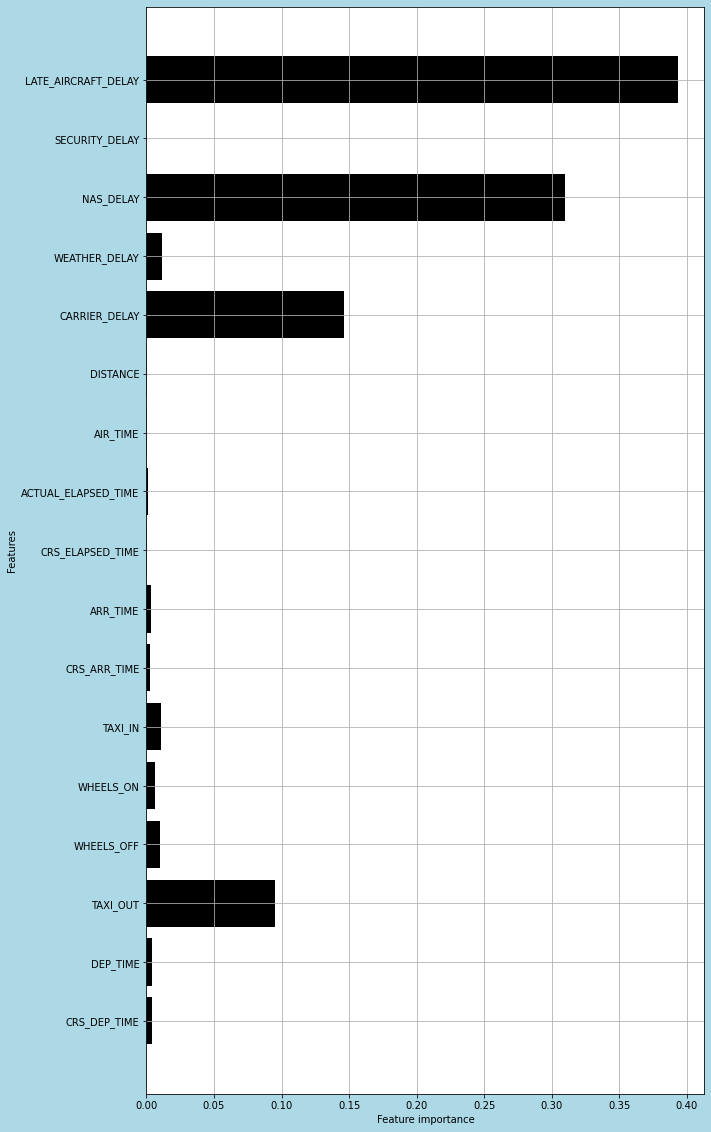

In [ ]:
#plot feature importance of Random Forest Classifier
plot_feature_importances(clf_before_feat_sel)
plt.rcParams["figure.facecolor"] = "lightblue"

In [26]:
model = SelectFromModel(clf_before_feat_sel,prefit=True)

In [85]:


X_feat_sel = model.transform(X_train)
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
print('After Feature selection:')
clf.fit(X_feat_sel, y_train)
print('features number: ', X_feat_sel.shape[1])
#check the accuracy score
print('clf train score: ',clf.score(X_feat_sel, y_train))


size_test = 20000
random_index_test = np.random.randint(0, X_test.shape[0]-size_test)
X_feat_sel_test = X_test.iloc[random_index_test:random_index_test+size_test,:]
y_feat_sel_test = y_test[random_index_test:random_index_test+size_test]
X_feat_sel_test = model.transform(X_feat_sel_test)
print('clf test score: ',clf.score(X_feat_sel_test, y_feat_sel_test))


After Feature selection:
features number:  4
clf train score:  0.8363
clf test score:  0.83615


In [86]:
# Test set predictions on all (Huge) test set
#X_test = model.transform(X_test)
pred = clf.predict(model.transform(X_test))

print('Testing Accuracy for Random Forest Classifier:', accuracy_score(y_test, pred))

Testing Accuracy for Random Forest Classifier: 0.8368093362104805


> As shown: test accuracy is almost same -> feature selection works very well..

In [87]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    910409
           1       1.00      0.54      0.70    503955

    accuracy                           0.84   1414364
   macro avg       0.90      0.77      0.80   1414364
weighted avg       0.87      0.84      0.82   1414364



In [88]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,909273,1136,910409
1,229675,274280,503955
All,1138948,275416,1414364


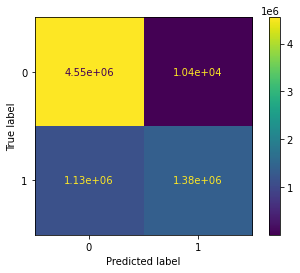

In [59]:
# Alternative confusion matrix
plot_confusion_matrix(clf, model.transform(X), y , values_format='.3g')
plt.show()

#### 2. Logistic Regression

In [104]:
print(X_train.shape)
print(X_test.shape)

(5657453, 17)
(1414364, 17)


In [105]:
clf_lr = LogisticRegression(solver='lbfgs',max_iter=200,random_state=1)
#X_train = model.transform(X_train)
clf_lr.fit(X_train, y_train)


LogisticRegression(max_iter=200, random_state=1)

In [106]:
y_pred = clf_lr.predict(X_test)
print('Testing Accuracy for Logistic Regression:', accuracy_score(y_test, y_pred))

Testing Accuracy for Logistic Regression: 0.8811303172309249


In [107]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, y_pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    910409
           1       0.92      0.73      0.81    503955

    accuracy                           0.88   1414364
   macro avg       0.89      0.85      0.86   1414364
weighted avg       0.89      0.88      0.88   1414364



In [108]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,879824,30585,910409
1,137540,366415,503955
All,1017364,397000,1414364


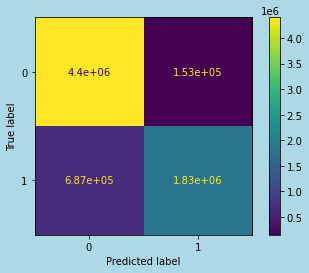

In [109]:
# Alternative confusion matrix
plot_confusion_matrix(clf_lr, X, y , values_format='.3g')
plt.show()

In [ ]:
# plot Logistic Regression graph
sns.regplot(x= y_test , y= y_pred , logistic=True, ci=None ,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

In [110]:
# Logistic Regression after feat selection:
clf_lr2 = LogisticRegression(solver='lbfgs',max_iter=200,random_state=1)
clf_lr2.fit(model.transform(X_train), y_train)
y_pred = clf_lr2.predict(model.transform(X_test))
print('Testing Accuracy for Logistic Regression:', accuracy_score(y_test, y_pred))

Testing Accuracy for Logistic Regression: 0.8279615431388242


In [111]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, y_pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.80      0.99      0.88    910409
           1       0.96      0.54      0.69    503955

    accuracy                           0.83   1414364
   macro avg       0.88      0.76      0.79   1414364
weighted avg       0.85      0.83      0.81   1414364



In [112]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,897629,12780,910409
1,230545,273410,503955
All,1128174,286190,1414364


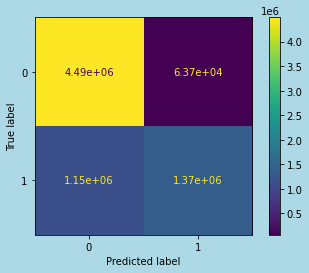

In [113]:
# Alternative confusion matrix
plot_confusion_matrix(clf_lr2, model.transform(X), y , values_format='.3g')
plt.show()

<AxesSubplot:>

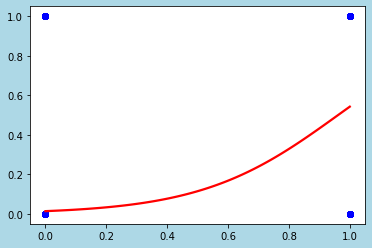

In [97]:
# plot Logistic Regression graph
sns.regplot(x= y_test , y= y_pred , logistic=True, ci=None ,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

In [32]:
#### FOR MAP REDUC ONLY:
X_map_reduce = model.transform(X)
print(X_map_reduce.shape)
dataset = pd.DataFrame(X_map_reduce)
dataset['Month'] = month_column
X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=0.2,random_state = 2)

(7071817, 4)


In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5657453, 5)
(5657453,)
(1414364, 5)
(1414364,)


In [35]:
X_train.columns

Index([0, 1, 2, 3, 'Month'], dtype='object')

In [36]:
# export dataset to be used in map_reduce:
export_dataset = pd.DataFrame(X_train)
export_dataset['Status'] = y_train
print(export_dataset.columns)

Index([0, 1, 2, 3, 'Month', 'Status'], dtype='object')


In [37]:
export_dataset.head(n=2)

,0,1,2,3,Month,Status
1628190,0.066667,0.0,0.001623,0.001222,3,0
449214,0.035897,0.0,0.001623,0.001222,1,0


In [38]:
#write the dataset for visualization using parquet dataformat , fast and low memory usage
export_dataset.to_csv("./classification.csv",index=False,header=False)

In [39]:
# export dataset to be used in map_reduce:
test_export_dataset = pd.DataFrame(X_test)
test_export_dataset['Status'] = y_test
print(test_export_dataset.columns)

Index([0, 1, 2, 3, 'Month', 'Status'], dtype='object')


In [ ]:
#write the dataset for visualization using parquet dataformat , fast and low memory usage
export_dataset.to_csv("./classification_test.csv",index=False,header=False)